In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

2024-08-17 03:47:37.205729: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 03:47:37.205856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 03:47:37.365310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
base_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_dir = 'train_set'
test_dir = 'test_set'

# Create directories for train and test sets if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get the list of classes (sub-folders)
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Loop through each class
for cls in classes:
    class_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    
    # Split the images into train and test sets
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    # Create class directories in the train and test folders
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)
    
    # Copy training images
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, cls, img)
        shutil.copyfile(src, dst)
    
    # Copy testing images
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, cls, img)
        shutil.copyfile(src, dst)

In [5]:
image_set =  "/kaggle/working/train_set"
test_set_directory = '/kaggle/working/test_set'

In [6]:
SIZE_X = SIZE_Y = 224

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       color_mode="rgb",
                                       batch_size = 128, 
                                       shuffle = False,
                                       subset='training',
                                       seed = 42)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split = 0.5)

validate_set = test_datagen.flow_from_directory(
       test_set_directory,
       class_mode = "categorical",
       target_size = (SIZE_X, SIZE_Y),
       color_mode="rgb",
       batch_size = 128, 
       shuffle = False,
       subset='training',
       seed = 42)


test_set = test_datagen.flow_from_directory(
    test_set_directory,
    class_mode='categorical',
    target_size=(SIZE_X, SIZE_Y),
    color_mode='rgb',
    batch_size=128,
    subset='validation',
    shuffle=False,  # No shuffling needed for testing
    seed = 42
)

Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [7]:
IMAGE_SIZE = [224, 224]

# EfficientNetB0

In [8]:
enb0 = EfficientNetB0(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in enb0.layers:
        layer.trainable = False


flatten = Flatten()(enb0.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

efnetB0 = Model(inputs=enb0.input, outputs=prediction)
efnetB0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 20,139,430 (76.83 MB)

 Trainable params: 16,089,859 (61.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
efnetB0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
batch_size = 128

# EfficientNetB0 training

In [11]:
history = efnetB0.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size, 
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/94 ━━━━━━━━━━━━━━━━━━━━ 1:14:05 48s/step - accuracy: 0.6484 - loss: 0.8832

I0000 00:00:1723866637.976213     137 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1723866638.033924     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


20/94 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.4857 - loss: 19.6950  

W0000 00:00:1723866675.442108     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.6147 - loss: 10.5424

W0000 00:00:1723866717.683389     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.6164 - loss: 10.4772 - val_accuracy: 0.9507 - val_loss: 0.1329
Epoch 2/5


W0000 00:00:1723866738.120152     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 542ms/step - accuracy: 0.9219 - loss: 0.2022 - val_accuracy: 0.9547 - val_loss: 0.1129
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 527ms/step - accuracy: 0.9486 - loss: 0.1250 - val_accuracy: 0.9733 - val_loss: 0.0687
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 533ms/step - accuracy: 0.9609 - loss: 0.0964 - val_accuracy: 0.9753 - val_loss: 0.0589
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 535ms/step - accuracy: 0.9821 - loss: 0.0474 - val_accuracy: 0.9653 - val_loss: 0.0903


In [12]:
def loss_curve(history):
    plt.plot(history.history['loss'],label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'testing_loss')
    plt.title('loss')
    plt.legend()
    plt.show()


In [13]:
def accuracy_curve(history):
    plt.plot(history.history['accuracy'], label='training_accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [14]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [15]:
def reports(model,test_set):
    from sklearn.metrics import confusion_matrix
    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred ,axis =1)
    print('Confusion Matrix')
    confusion_matrix = confusion_matrix(test_set.classes, y_pred)
    print(confusion_matrix)
    print('Classification Report')
    target_names = ['aca','n', 'scc']
    print(classification_report(test_set.classes, y_pred, target_names=target_names))

In [16]:
def report_accracy(model, test_set):

    Y_pred = model.predict(test_set)
    y_pred = np.argmax(Y_pred, axis=1)
    
    cm = confusion_matrix(test_set.classes, y_pred)
    report = classification_report(test_set.classes, y_pred, output_dict=True)
    overall_accuracy = report['accuracy']
    
    return overall_accuracy

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 480ms/step - accuracy: 0.9847 - loss: 0.0427
test_loss, test accuracy [0.1044728010892868, 0.9633333086967468]


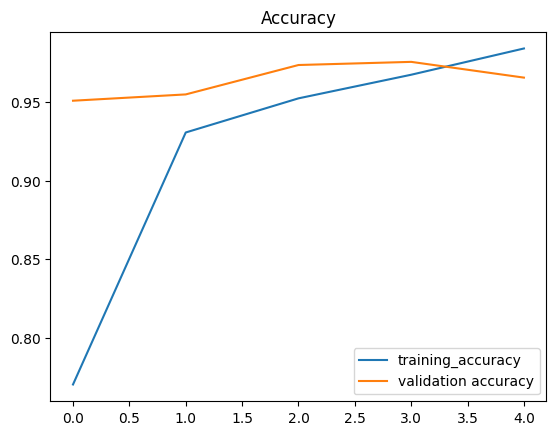

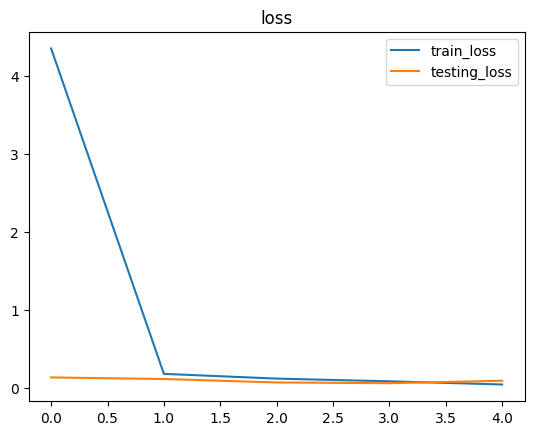

 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step

W0000 00:00:1723866968.136857     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 952ms/step
Confusion Matrix
[[496   3   1]
 [  1 499   0]
 [ 50   0 450]]
Classification Report
              precision    recall  f1-score   support

         aca       0.91      0.99      0.95       500
           n       0.99      1.00      1.00       500
         scc       1.00      0.90      0.95       500

    accuracy                           0.96      1500
   macro avg       0.97      0.96      0.96      1500
weighted avg       0.97      0.96      0.96      1500



W0000 00:00:1723866978.604970     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [17]:
result = efnetB0.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

accuracy_curve(history)
loss_curve(history)
reports(efnetB0,test_set)

In [18]:
r_accuracy = report_accracy(efnetB0,test_set) * 100
formatted_accuracy = f"{r_accuracy:.2f}"
print(formatted_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 493ms/step
96.33


# RESNET50

In [19]:
resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Set the layers of ResNet50 to non-trainable
for layer in resnet50.layers:
    layer.trainable = False

# Add new layers for custom classification
flatten = Flatten()(resnet50.output)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(128, activation='relu')(dense1)
prediction = Dense(train_set.num_classes, activation='softmax')(dense2)

# Create the new model
resnet50_model = Model(inputs=resnet50.input, outputs=prediction)

# Print the model summary
resnet50_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,311,363 (188.11 MB)

 Trainable params: 25,723,651 (98.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
batch_size = 128

# RESNET50 training

In [22]:
history = resnet50_model.fit(
    train_set,
    validation_data=validate_set,
    epochs=5,
    verbose=1,
    steps_per_epoch=len(train_set) // batch_size,
    validation_steps=len(validate_set) // batch_size
)

Epoch 1/5


W0000 00:00:1723867025.878935     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


24/94 ━━━━━━━━━━━━━━━━━━━━ 1:32 1s/step - accuracy: 0.4509 - loss: 49.3306  

W0000 00:00:1723867056.211019     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.6532 - loss: 23.2751

W0000 00:00:1723867094.815564     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 129s 989ms/step - accuracy: 0.6543 - loss: 23.1329 - val_accuracy: 0.8507 - val_loss: 0.9899
Epoch 2/5


W0000 00:00:1723867117.927368     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 566ms/step - accuracy: 0.8907 - loss: 0.5815 - val_accuracy: 0.9607 - val_loss: 0.1123
Epoch 3/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 561ms/step - accuracy: 0.9713 - loss: 0.0824 - val_accuracy: 0.9793 - val_loss: 0.0636
Epoch 4/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 558ms/step - accuracy: 0.9880 - loss: 0.0310 - val_accuracy: 0.9813 - val_loss: 0.0442
Epoch 5/5
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 552ms/step - accuracy: 0.9939 - loss: 0.0193 - val_accuracy: 0.9780 - val_loss: 0.0546


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - accuracy: 0.9887 - loss: 0.0321
Test loss, test accuracy: [0.06698977947235107, 0.9766666889190674]


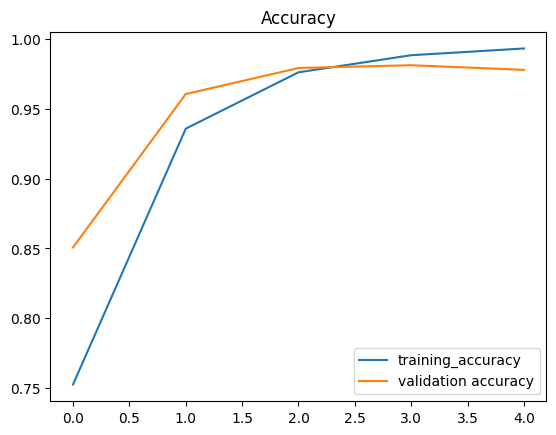

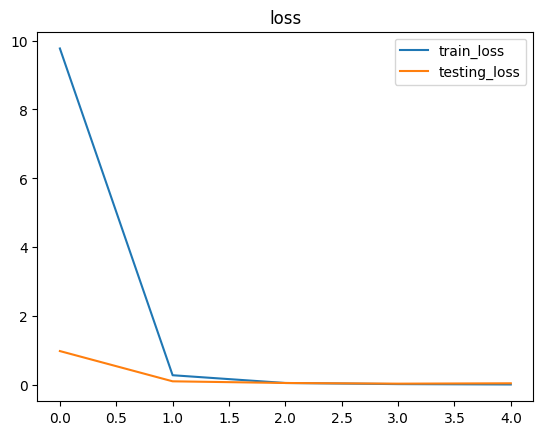

 1/12 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step

W0000 00:00:1723867355.900078     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 771ms/step


W0000 00:00:1723867364.381916     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Confusion Matrix
[[496   1   3]
 [  0 500   0]
 [ 31   0 469]]
Classification Report
              precision    recall  f1-score   support

         aca       0.94      0.99      0.97       500
           n       1.00      1.00      1.00       500
         scc       0.99      0.94      0.97       500

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [23]:
result = resnet50_model.evaluate(test_set, batch_size=128)
print("Test loss, test accuracy:", result)

accuracy_curve(history)
loss_curve(history)

reports(resnet50_model, test_set)

In [24]:
r_accuracy = report_accracy(resnet50_model,test_set) * 100
formatted_accuracy = f"{r_accuracy:.2f}"
print(formatted_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 482ms/step
97.67


# Model 1

In [25]:
import keras
from tensorflow.keras import layers, models, Input

In [26]:
model_1 = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)


model_1.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from tensorflow.keras import layers, models, optimizers, losses

In [28]:
model_1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss=losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

history = model_1.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 755ms/step - accuracy: 0.4374 - loss: 61.7108 - val_accuracy: 0.6947 - val_loss: 0.9823
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.7434 - loss: 0.6865 - val_accuracy: 0.7867 - val_loss: 0.3675
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 55s 545ms/step - accuracy: 0.8068 - loss: 0.3766 - val_accuracy: 0.8860 - val_loss: 0.2337
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 541ms/step - accuracy: 0.8518 - loss: 0.2604 - val_accuracy: 0.7540 - val_loss: 0.3861
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 533ms/step - accuracy: 0.8047 - loss: 0.3846 - val_accuracy: 0.7760 - val_loss: 0.3286
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 539ms/step - accuracy: 0.8439 - loss: 0.2793 - val_accuracy: 0.7827 - val_loss: 0.3153
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 56s 552ms/step - accuracy: 0.7868 - loss: 0.3576 - val_accuracy: 0.8793 - val_loss: 0.2086
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 54s 537ms/step - accuracy: 0.8735 - loss: 0.2084 - val_acc

In [29]:
result = model_1.evaluate(test_set, batch_size=128)
print("test_loss, test accuracy", result)

# Generate classification reports
reports(model_1, test_set)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 516ms/step - accuracy: 0.7814 - loss: 0.3504
test_loss, test accuracy [0.25407034158706665, 0.8706666827201843]
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step
Confusion Matrix
[[338  39 123]
 [  1 499   0]
 [ 31   0 469]]
Classification Report
              precision    recall  f1-score   support

         aca       0.91      0.68      0.78       500
           n       0.93      1.00      0.96       500
         scc       0.79      0.94      0.86       500

    accuracy                           0.87      1500
   macro avg       0.88      0.87      0.87      1500
weighted avg       0.88      0.87      0.87      1500



In [30]:
r_accuracy = report_accracy(model_1,test_set) * 100
formatted_accuracy = f"{r_accuracy:.2f}"
print(formatted_accuracy)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step
87.07


# Knowledge Distillation

In [31]:
import os
import keras
from keras import layers
from keras import ops
import numpy as np

In [32]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.3,
        temperature=3,
    ):
        """Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def compute_loss(
        self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False
    ):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = self.distillation_loss_fn(
            ops.softmax(teacher_pred / self.temperature, axis=1),
            ops.softmax(y_pred / self.temperature, axis=1),
        ) * (self.temperature**2)

        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

# Model 1 KD

In [33]:
model_1_kd = keras.Sequential(
    [
        keras.Input(shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(128,(3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(256,(3, 3), strides=(2, 2), padding="same"),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(3, activation='softmax'),
    ],
)

model_1_kd.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │       150,531 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,931 (2.55 MB)

 Trainable params: 668,931 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
data = []

In [56]:
data = {
    'Alpha': ['0.3', '0.3', '0.3', '0.3','0.3','0.3', '0.3', '0.3', '0.3','0.3'],
    'Temparature': [7,10,20,40,46,47,50,61,62,64],
    'Accuracy': ['91.46', '90.33', '92.26', '89.66','90.20', '89.66', '89.93','89.93','90.86','89.80'],
}

# Create a DataFrame
df = pd.DataFrame(data)
df

,Alpha,Temparature,Accuracy
0,0.3,7,91.46
1,0.3,10,90.33
2,0.3,20,92.26
3,0.3,40,89.66
4,0.3,46,90.20
5,0.3,47,89.66
6,0.3,50,89.93
7,0.3,61,89.93
8,0.3,62,90.86
9,0.3,64,89.80


Training with temperature: 7
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723874225.624523     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/94 ━━━━━━━━━━━━━━━━━━━━ 35s 534ms/step - accuracy: 0.5893 - loss: 0.0000e+00

W0000 00:00:1723874245.188998     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.6189 - loss: 0.0000e+00

W0000 00:00:1723874286.740094     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723874294.733215     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 741ms/step - accuracy: 0.6194 - loss: 0.0000e+00 - val_accuracy: 0.6900 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.7191 - loss: 0.0000e+00 - val_accuracy: 0.6793 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 599ms/step - accuracy: 0.7732 - loss: 0.0000e+00 - val_accuracy: 0.8207 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 612ms/step - accuracy: 0.7946 - loss: 0.0000e+00 - val_accuracy: 0.7900 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 603ms/step - accuracy: 0.8356 - loss: 0.0000e+00 - val_accuracy: 0.8860 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 601ms/step - accuracy: 0.8800 - loss: 0.0000e+00 - val_accuracy: 0.7700 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 607ms/step - accuracy: 0.8452 - loss: 0.0000e+00 - val_accuracy: 0.8293 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 600ms/step

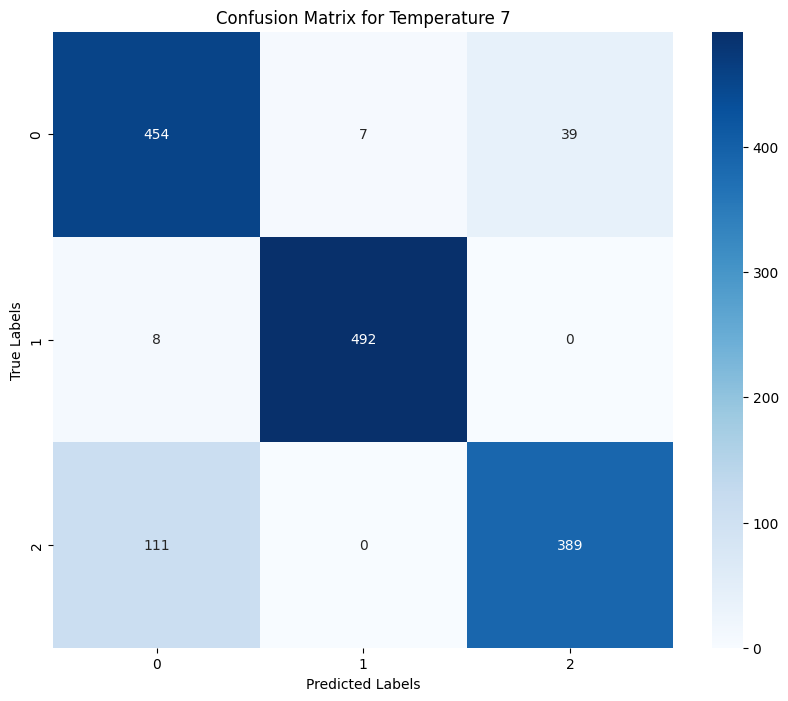

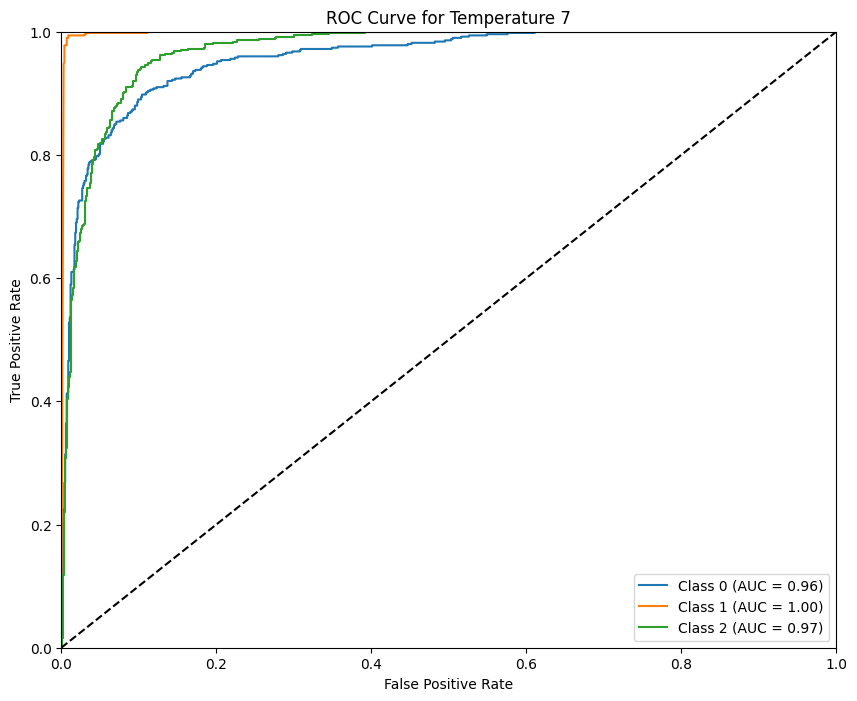

Training with temperature: 10
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723874875.212319     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/94 ━━━━━━━━━━━━━━━━━━━━ 23s 532ms/step - accuracy: 0.6409 - loss: 0.0000e+00

W0000 00:00:1723874906.430547     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.6769 - loss: 0.0000e+00

W0000 00:00:1723874935.631252     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723874943.662409     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 734ms/step - accuracy: 0.6775 - loss: 0.0000e+00 - val_accuracy: 0.7200 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 610ms/step - accuracy: 0.6857 - loss: 0.0000e+00 - val_accuracy: 0.7533 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 610ms/step - accuracy: 0.7014 - loss: 0.0000e+00 - val_accuracy: 0.6913 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 599ms/step - accuracy: 0.8027 - loss: 0.0000e+00 - val_accuracy: 0.7980 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 590ms/step - accuracy: 0.8377 - loss: 0.0000e+00 - val_accuracy: 0.8487 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 82s 593ms/step - accuracy: 0.8873 - loss: 0.0000e+00 - val_accuracy: 0.8387 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 611ms/step - accuracy: 0.8831 - loss: 0.0000e+00 - val_accuracy: 0.8560 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 616ms/step

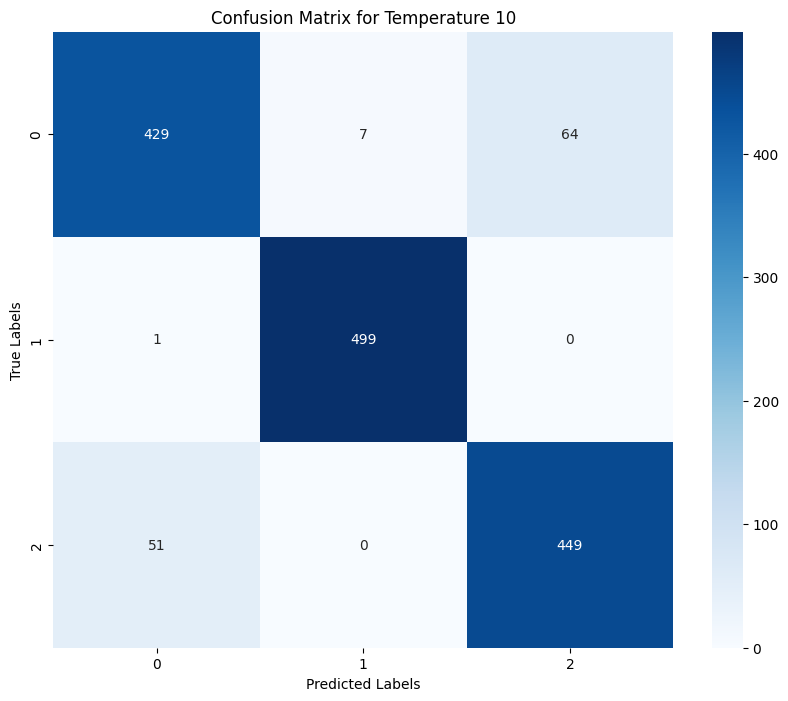

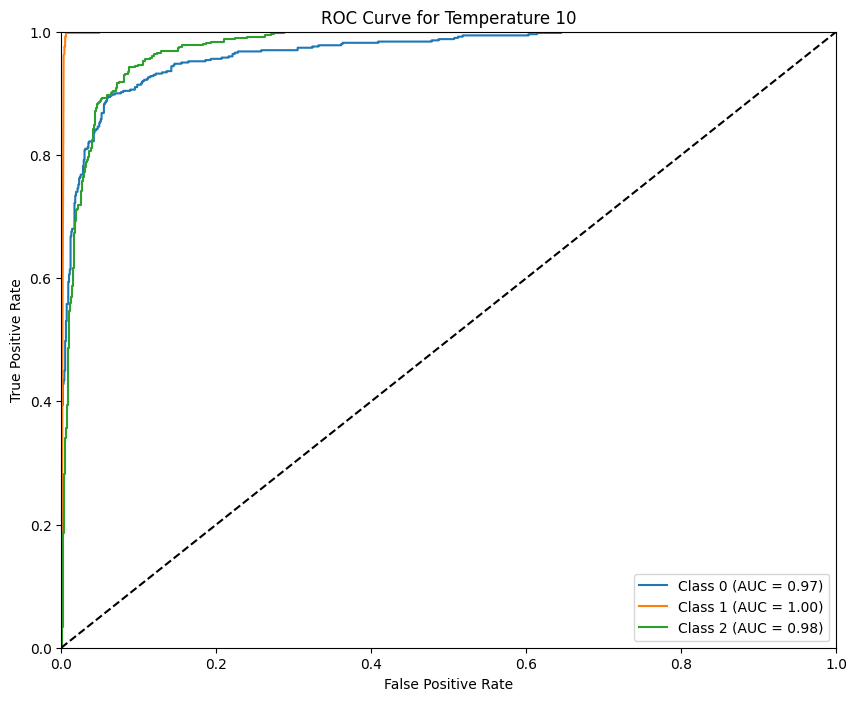

Training with temperature: 20
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723875593.085261     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/94 ━━━━━━━━━━━━━━━━━━━━ 3s 524ms/step - accuracy: 0.6355 - loss: 0.0000e+00

W0000 00:00:1723875643.382094     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6411 - loss: 0.0000e+00

W0000 00:00:1723875652.967559     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723875660.772038     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 88s 725ms/step - accuracy: 0.6418 - loss: 0.0000e+00 - val_accuracy: 0.7853 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 599ms/step - accuracy: 0.7183 - loss: 0.0000e+00 - val_accuracy: 0.6527 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 585ms/step - accuracy: 0.7864 - loss: 0.0000e+00 - val_accuracy: 0.7787 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.8618 - loss: 0.0000e+00 - val_accuracy: 0.7713 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.8726 - loss: 0.0000e+00 - val_accuracy: 0.8740 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 595ms/step - accuracy: 0.9119 - loss: 0.0000e+00 - val_accuracy: 0.8660 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 613ms/step - accuracy: 0.9107 - loss: 0.0000e+00 - val_accuracy: 0.8793 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 613ms/step

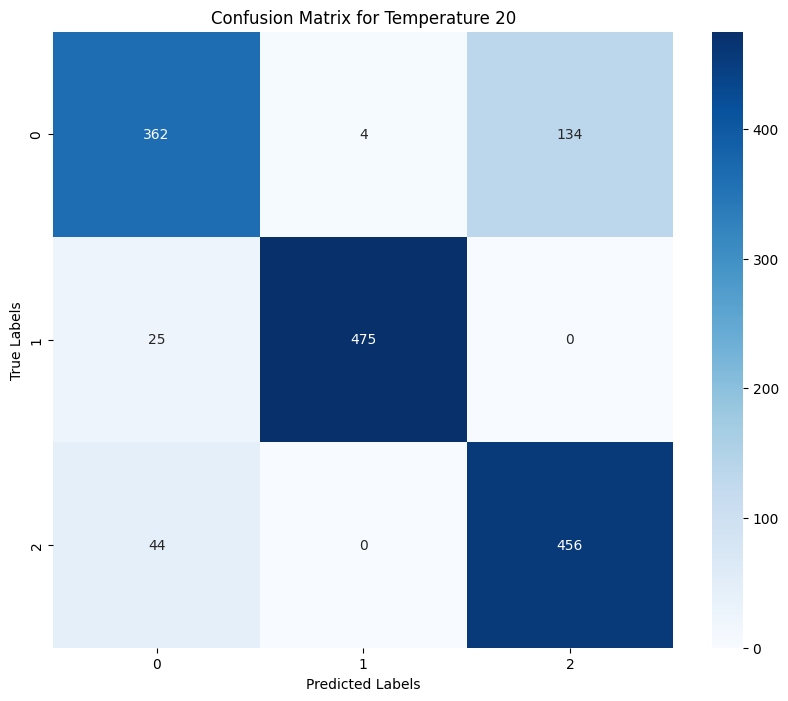

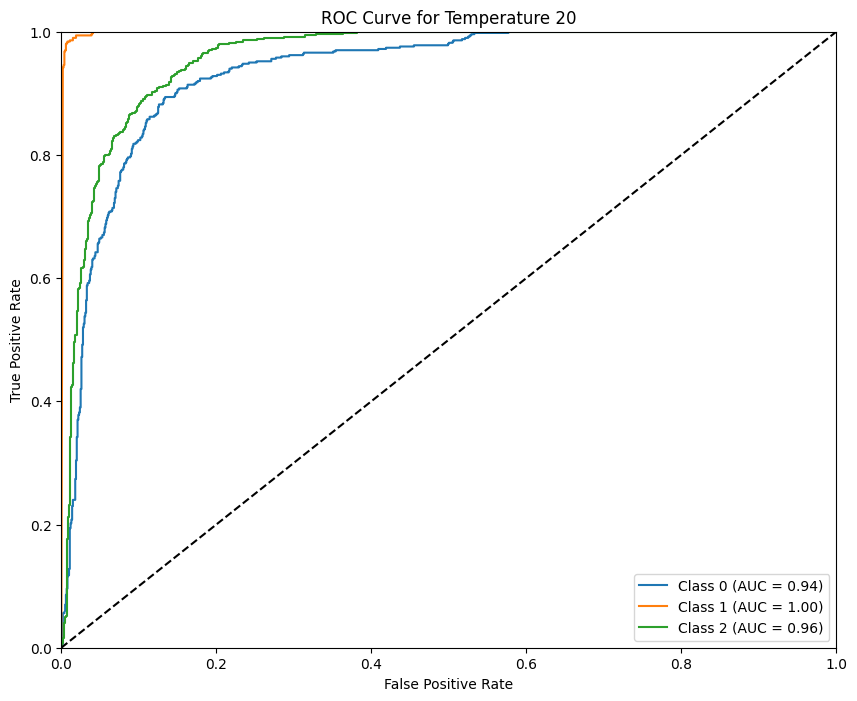

Training with temperature: 40
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723876239.666126     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


16/94 ━━━━━━━━━━━━━━━━━━━━ 40s 517ms/step - accuracy: 0.6912 - loss: 0.0000e+00

W0000 00:00:1723876252.588547     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - accuracy: 0.6898 - loss: 0.0000e+00

W0000 00:00:1723876299.870282     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723876308.058027     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 733ms/step - accuracy: 0.6901 - loss: 0.0000e+00 - val_accuracy: 0.6873 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 602ms/step - accuracy: 0.8021 - loss: 0.0000e+00 - val_accuracy: 0.8347 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 602ms/step - accuracy: 0.8287 - loss: 0.0000e+00 - val_accuracy: 0.8620 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.9150 - loss: 0.0000e+00 - val_accuracy: 0.8807 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 596ms/step - accuracy: 0.9335 - loss: 0.0000e+00 - val_accuracy: 0.8867 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - accuracy: 0.9246 - loss: 0.0000e+00 - val_accuracy: 0.8907 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 616ms/step - accuracy: 0.9425 - loss: 0.0000e+00 - val_accuracy: 0.9040 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 599ms/step

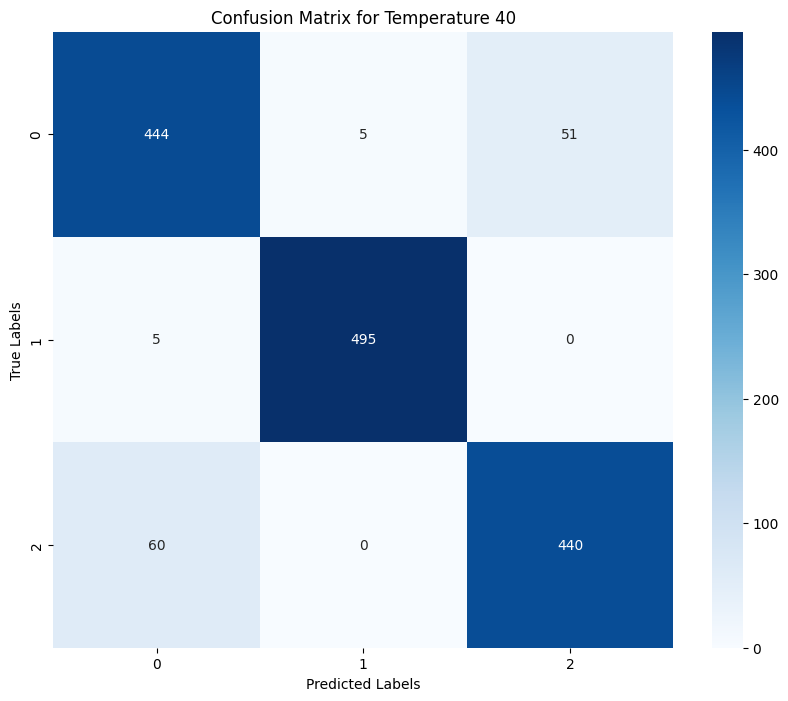

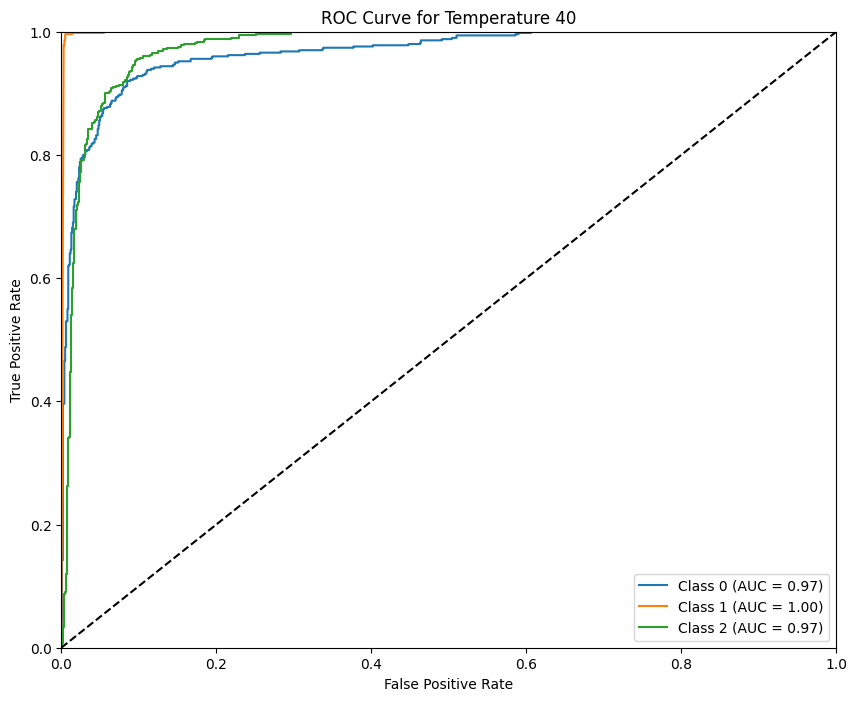

Training with temperature: 46
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723876909.782901     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


43/94 ━━━━━━━━━━━━━━━━━━━━ 26s 518ms/step - accuracy: 0.6869 - loss: 0.0000e+00

W0000 00:00:1723876936.778530     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6758 - loss: 0.0000e+00

W0000 00:00:1723876969.913398     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723876978.043471     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 732ms/step - accuracy: 0.6759 - loss: 0.0000e+00 - val_accuracy: 0.6740 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 593ms/step - accuracy: 0.7298 - loss: 0.0000e+00 - val_accuracy: 0.8500 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 600ms/step - accuracy: 0.8570 - loss: 0.0000e+00 - val_accuracy: 0.8880 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 605ms/step - accuracy: 0.9200 - loss: 0.0000e+00 - val_accuracy: 0.8693 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - accuracy: 0.8750 - loss: 0.0000e+00 - val_accuracy: 0.8307 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 591ms/step - accuracy: 0.8921 - loss: 0.0000e+00 - val_accuracy: 0.8860 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 83s 602ms/step - accuracy: 0.9454 - loss: 0.0000e+00 - val_accuracy: 0.8913 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 617ms/step

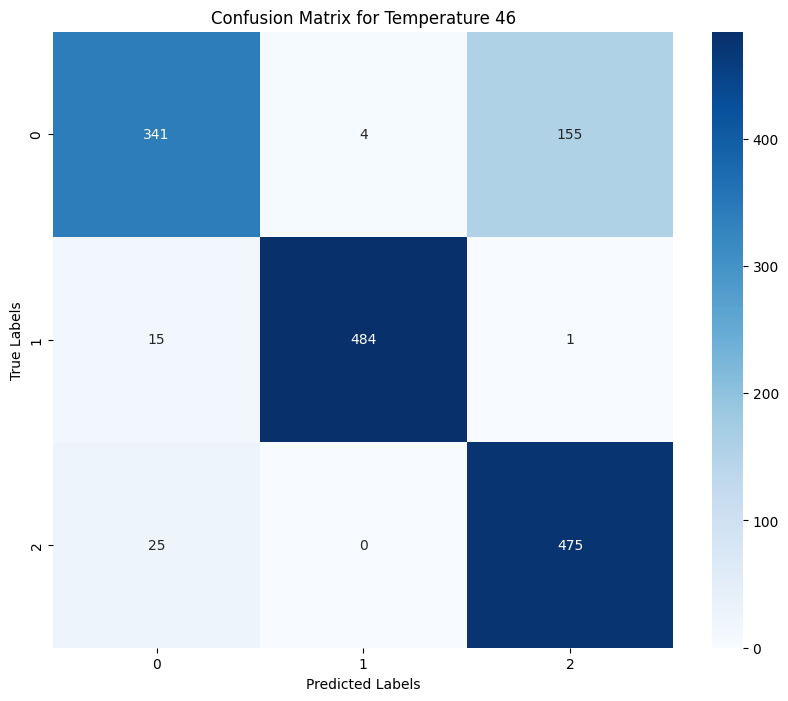

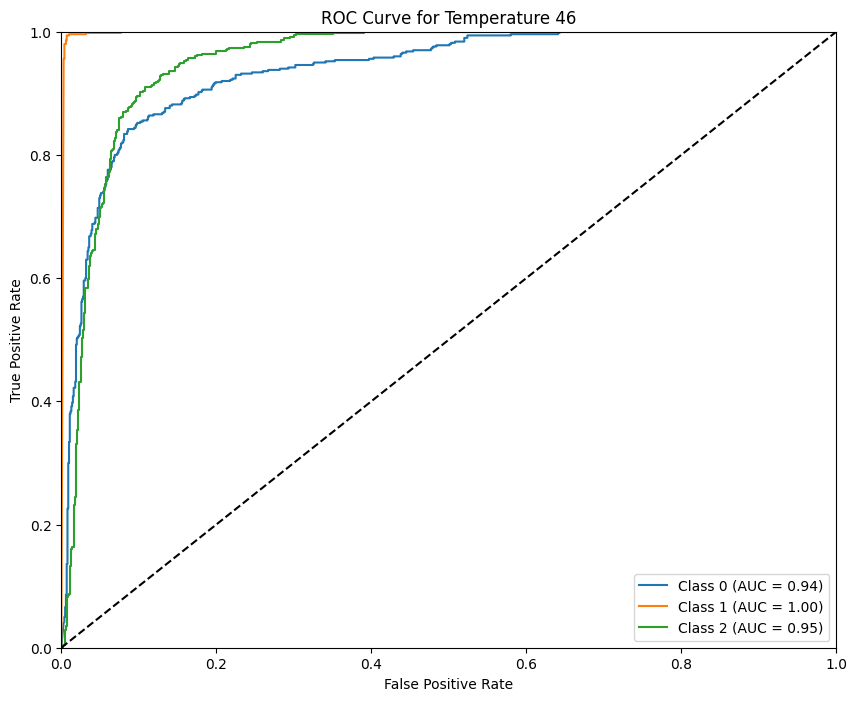

Training with temperature: 47
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723877578.171124     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


64/94 ━━━━━━━━━━━━━━━━━━━━ 16s 536ms/step - accuracy: 0.6757 - loss: 0.0000e+00

W0000 00:00:1723877617.112849     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - accuracy: 0.6643 - loss: 0.0000e+00

W0000 00:00:1723877638.727561     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723877646.640747     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 86s 734ms/step - accuracy: 0.6640 - loss: 0.0000e+00 - val_accuracy: 0.7560 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.7197 - loss: 0.0000e+00 - val_accuracy: 0.8387 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 588ms/step - accuracy: 0.7872 - loss: 0.0000e+00 - val_accuracy: 0.8600 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 608ms/step - accuracy: 0.8861 - loss: 0.0000e+00 - val_accuracy: 0.8600 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 605ms/step - accuracy: 0.8826 - loss: 0.0000e+00 - val_accuracy: 0.8553 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.9227 - loss: 0.0000e+00 - val_accuracy: 0.8687 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 609ms/step - accuracy: 0.9383 - loss: 0.0000e+00 - val_accuracy: 0.8693 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 606ms/step

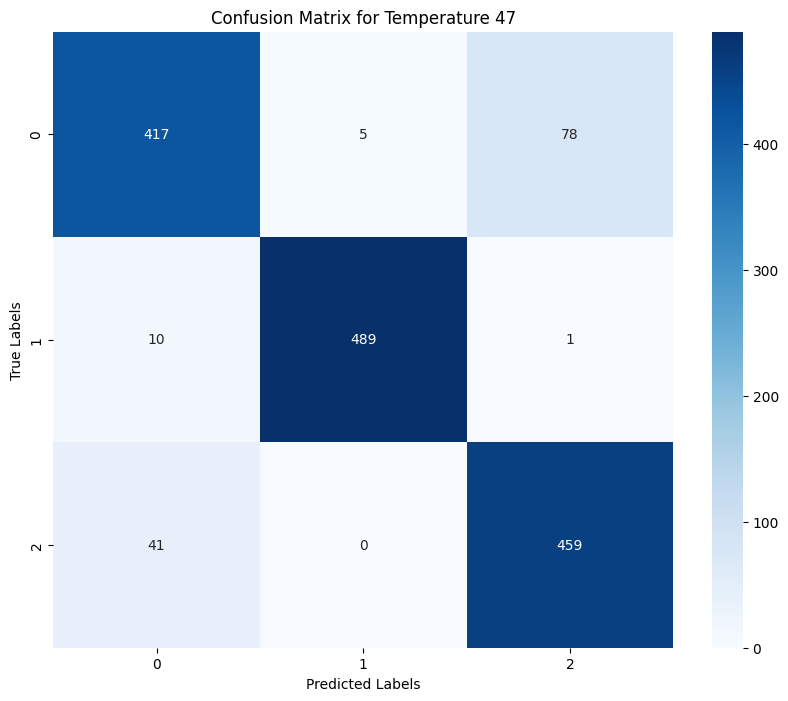

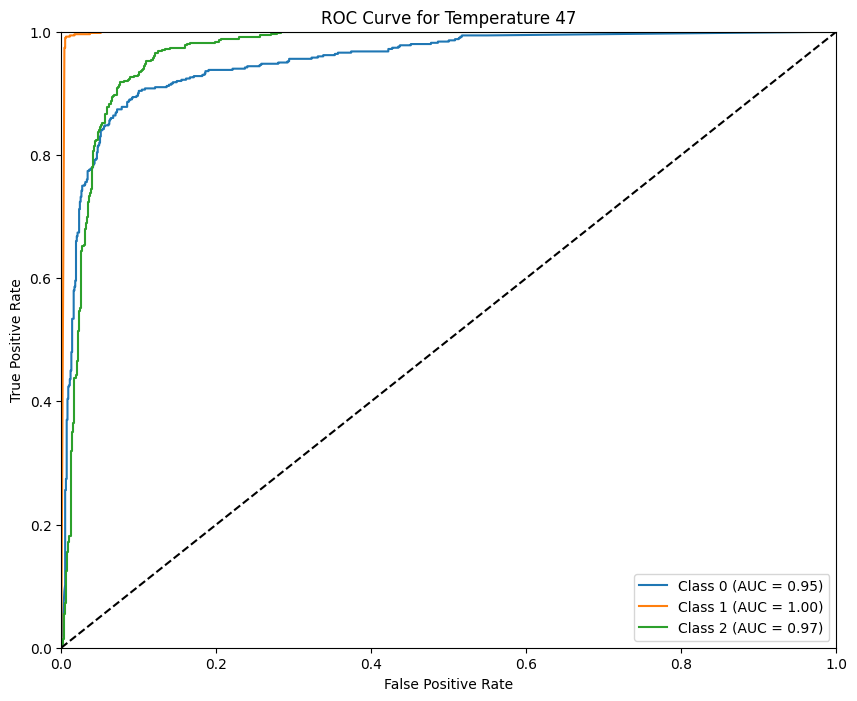

Training with temperature: 50
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723878225.260146     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/94 ━━━━━━━━━━━━━━━━━━━━ 32s 539ms/step - accuracy: 0.5846 - loss: 0.0000e+00

W0000 00:00:1723878247.317360     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6320 - loss: 0.0000e+00

W0000 00:00:1723878284.763055     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723878292.545229     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 721ms/step - accuracy: 0.6325 - loss: 0.0000e+00 - val_accuracy: 0.6860 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 601ms/step - accuracy: 0.7294 - loss: 0.0000e+00 - val_accuracy: 0.7000 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 602ms/step - accuracy: 0.7586 - loss: 0.0000e+00 - val_accuracy: 0.8520 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 584ms/step - accuracy: 0.8840 - loss: 0.0000e+00 - val_accuracy: 0.8640 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 603ms/step - accuracy: 0.9289 - loss: 0.0000e+00 - val_accuracy: 0.8553 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 610ms/step - accuracy: 0.9424 - loss: 0.0000e+00 - val_accuracy: 0.8127 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - accuracy: 0.9294 - loss: 0.0000e+00 - val_accuracy: 0.8887 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 601ms/step

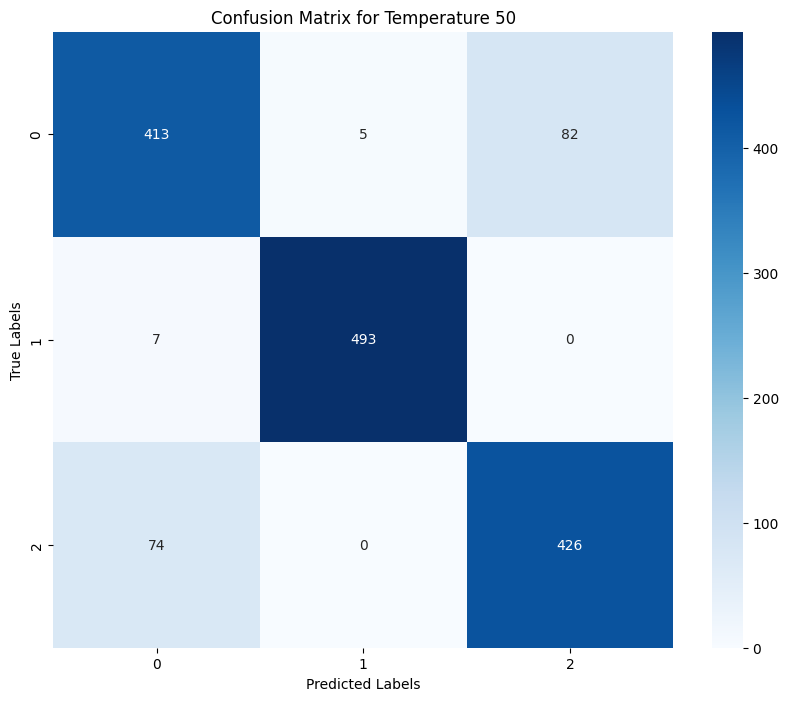

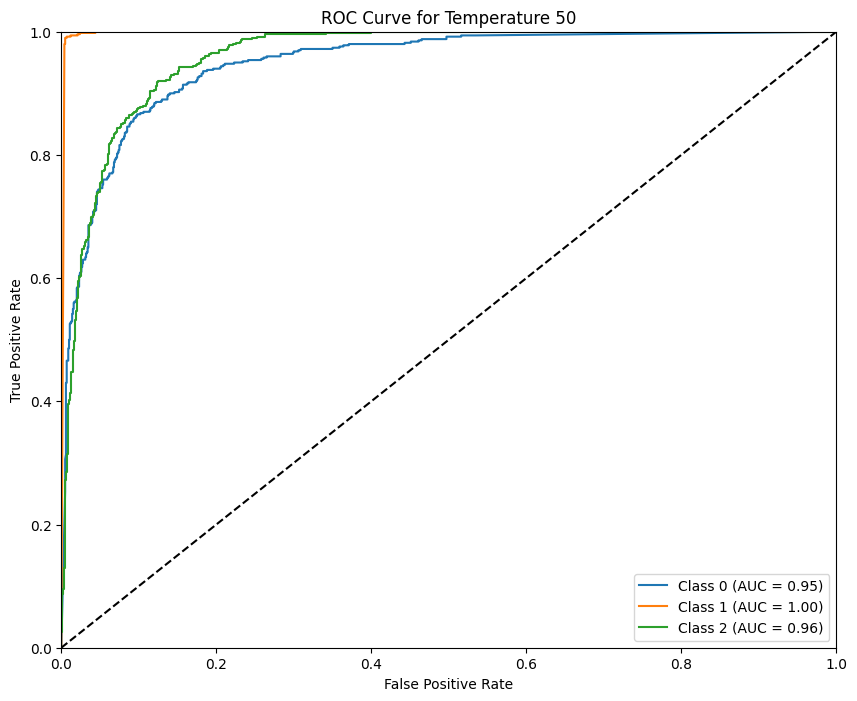

Training with temperature: 61
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723878870.632155     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


57/94 ━━━━━━━━━━━━━━━━━━━━ 19s 540ms/step - accuracy: 0.6414 - loss: 0.0000e+00

W0000 00:00:1723878905.228926     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - accuracy: 0.6376 - loss: 0.0000e+00

W0000 00:00:1723878930.021933     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723878937.426726     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 84s 716ms/step - accuracy: 0.6377 - loss: 0.0000e+00 - val_accuracy: 0.8220 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 597ms/step - accuracy: 0.8293 - loss: 0.0000e+00 - val_accuracy: 0.8260 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - accuracy: 0.8849 - loss: 0.0000e+00 - val_accuracy: 0.8853 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.9343 - loss: 0.0000e+00 - val_accuracy: 0.8307 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 601ms/step - accuracy: 0.9326 - loss: 0.0000e+00 - val_accuracy: 0.8880 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 596ms/step - accuracy: 0.9413 - loss: 0.0000e+00 - val_accuracy: 0.9033 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - accuracy: 0.9575 - loss: 0.0000e+00 - val_accuracy: 0.9033 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 605ms/step

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


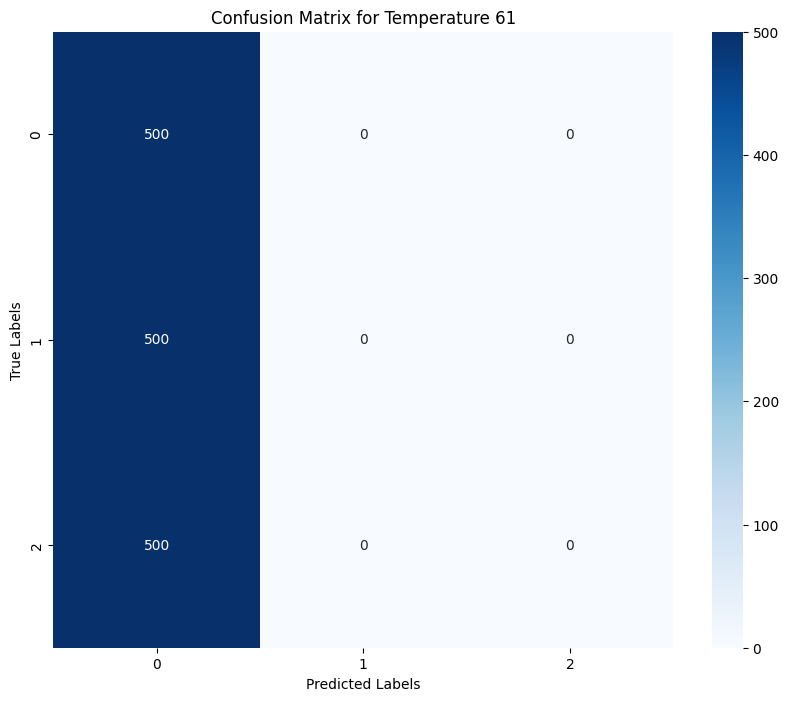

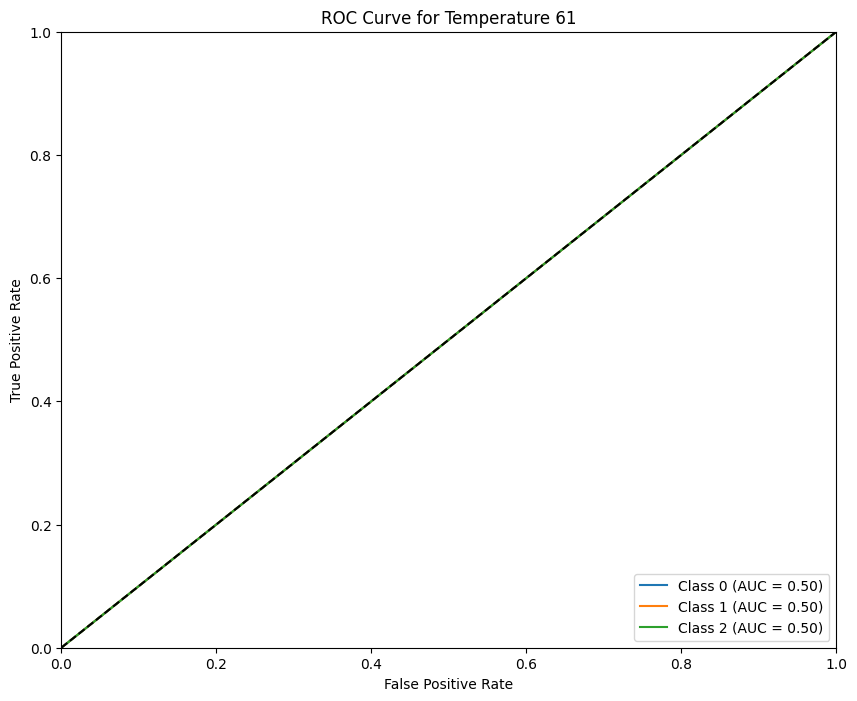

Training with temperature: 62
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723879536.738012     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/94 ━━━━━━━━━━━━━━━━━━━━ 33s 526ms/step - accuracy: 0.4636 - loss: 0.0000e+00

W0000 00:00:1723879557.202878     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.5442 - loss: 0.0000e+00

W0000 00:00:1723879599.271426     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723879607.044361     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 88s 754ms/step - accuracy: 0.5445 - loss: 0.0000e+00 - val_accuracy: 0.7020 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 600ms/step - accuracy: 0.6758 - loss: 0.0000e+00 - val_accuracy: 0.7820 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.7295 - loss: 0.0000e+00 - val_accuracy: 0.7600 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 610ms/step - accuracy: 0.7005 - loss: 0.0000e+00 - val_accuracy: 0.7453 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 611ms/step - accuracy: 0.7981 - loss: 0.0000e+00 - val_accuracy: 0.8460 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 605ms/step - accuracy: 0.8324 - loss: 0.0000e+00 - val_accuracy: 0.8373 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 605ms/step - accuracy: 0.7792 - loss: 0.0000e+00 - val_accuracy: 0.8580 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 592ms/step

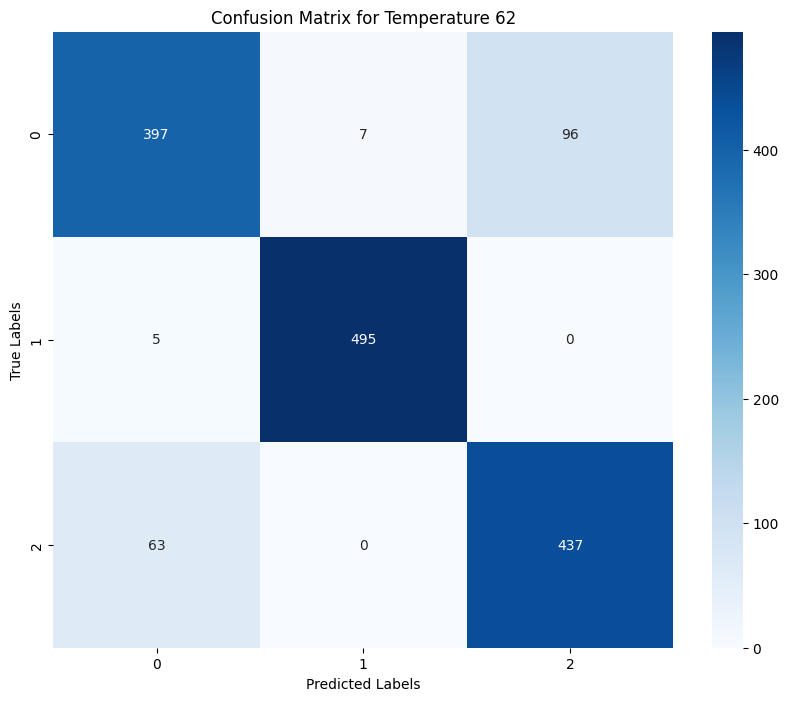

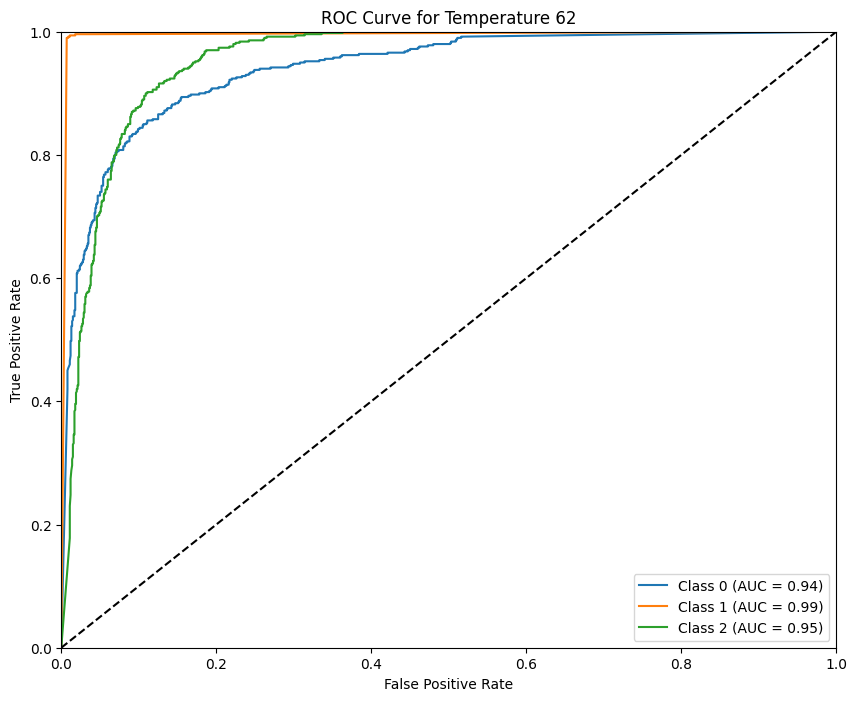

Training with temperature: 64
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:560: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
W0000 00:00:1723880190.066489     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/94 ━━━━━━━━━━━━━━━━━━━━ 3s 518ms/step - accuracy: 0.6206 - loss: 0.0000e+00

W0000 00:00:1723880239.812121     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.6185 - loss: 0.0000e+00

W0000 00:00:1723880249.423158     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1723880257.420273     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 85s 722ms/step - accuracy: 0.6183 - loss: 0.0000e+00 - val_accuracy: 0.8273 - val_loss: 0.0000e+00
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.7783 - loss: 0.0000e+00 - val_accuracy: 0.8240 - val_loss: 0.0000e+00
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 619ms/step - accuracy: 0.8666 - loss: 0.0000e+00 - val_accuracy: 0.8593 - val_loss: 0.0000e+00
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 604ms/step - accuracy: 0.8761 - loss: 0.0000e+00 - val_accuracy: 0.7467 - val_loss: 0.0000e+00
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 607ms/step - accuracy: 0.7742 - loss: 0.0000e+00 - val_accuracy: 0.7840 - val_loss: 0.0000e+00
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 60s 594ms/step - accuracy: 0.8818 - loss: 0.0000e+00 - val_accuracy: 0.8533 - val_loss: 0.0000e+00
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 61s 603ms/step - accuracy: 0.9065 - loss: 0.0000e+00 - val_accuracy: 0.8547 - val_loss: 0.0000e+00
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 62s 610ms/step

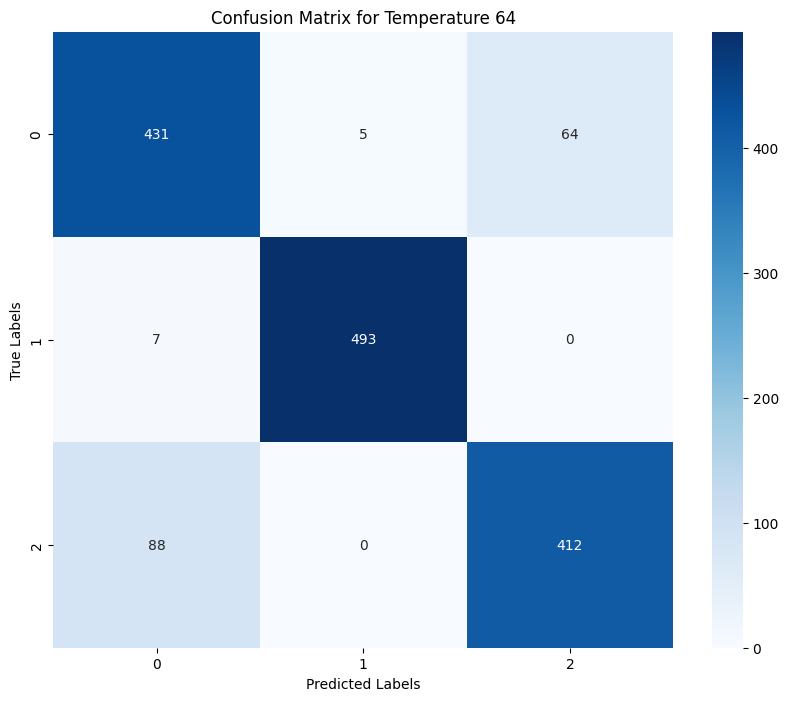

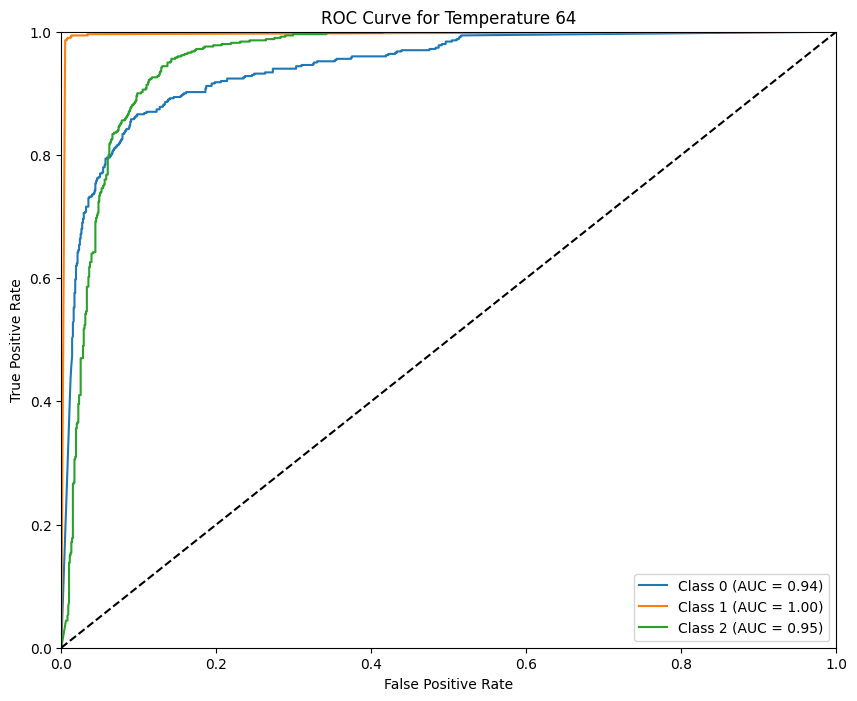

In [60]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


temperatures = [7,10,20,40,46,47,50,61,62,64]
results = []

num_classes = len(train_set.class_indices)

# Distiller model initialization
distiller_model1 = Distiller(student=model_1_kd, teacher=resnet50_model)

for temp in temperatures:
    print(f"Training with temperature: {temp}")
    
    distiller_model1.compile(
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy'],
        student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.3,
        temperature=temp
    )

    distiller_model1.fit(train_set, validation_data=validate_set, epochs=10, verbose=1)

    result = distiller_model1.evaluate(test_set, batch_size=128, verbose=0)
    test_accuracy = result[2]  

    y_pred = distiller_model1.predict(test_set, batch_size=128, verbose=0)
    y_true = test_set.labels  

    y_pred_classes = y_pred.argmax(axis=1)

    if len(y_true.shape) == 1:
        y_true_classes = y_true
    else:
        y_true_classes = y_true.argmax(axis=1)

    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    # Store the results
    results.append({
        'Alpha': 0.3, 
        'Temperature': temp, 
        'Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })
    
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for Temperature {temp}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    y_true_bin = label_binarize(y_true_classes, classes=list(range(num_classes)))

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Temperature {temp}')
    plt.legend(loc='lower right')
    plt.show()

In [63]:
results_df = pd.DataFrame(results)
results_df

,Alpha,Temperature,Accuracy,Precision,Recall,F1 Score
0,0.3,7,0.890000,0.895724,0.890000,0.889858
1,0.3,10,0.918000,0.917767,0.918000,0.917714
2,0.3,20,0.862000,0.868146,0.862000,0.861578
3,0.3,40,0.919333,0.919476,0.919333,0.919357
4,0.3,46,0.866667,0.879863,0.866667,0.864614
5,0.3,47,0.910000,0.911355,0.910000,0.909956
6,0.3,50,0.888000,0.888192,0.888000,0.888067
7,0.3,61,0.333333,0.111111,0.333333,0.166667
8,0.3,62,0.886000,0.886569,0.886000,0.885634
9,0.3,64,0.890667,0.891633,0.890667,0.890798
